In [2]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import random
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== PREPROCESSING FUNCTIONS ====================
print("\n" + "="*80)
print("DEFINING PREPROCESSING FUNCTIONS")
print("="*80)

def clean_text(text):
    """
    Preprocessing sederhana: hanya menghilangkan URL, mention, hashtag, email, 
    tanda baca (titik, koma), dan emote
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Hapus mention (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Hapus hashtag (#hashtag)
    text = re.sub(r'#\w+', '', text)
    
    # Hapus email
    text = re.sub(r'\S+@\S+', '', text)
    
    # Hapus tanda baca (titik, koma, dll) dan karakter khusus
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Hapus karakter berulang lebih dari 2 kali
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    # Hapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text)
    
    # Strip whitespace di awal dan akhir
    text = text.strip()
    
    # Lowercase
    text = text.lower()
    
    return text

print("Preprocessing functions defined!")


Using device: cpu

DEFINING PREPROCESSING FUNCTIONS
Preprocessing functions defined!


In [3]:
import random

def synonym_replacement(text, n=1):
    """Simple synonym replacement"""
    words = text.split()
    if len(words) < 2:
        return text
    
    synonyms = {
        "bagus": ["baik", "oke", "mantap"],
        "jelek": ["buruk", "tidak bagus", "kurang"],
        "lambat": ["lelet", "lemot", "lama"],
        "cepat": ["kilat", "segera", "langsung"],
        "mudah": ["gampang", "simple"],
        "susah": ["sulit", "ribet", "rumit"],
        "error": ["bug", "masalah"],
        "aplikasi": ["app", "platform"],
        "login": ["masuk", "sign in"],
        "otp": ["kode verifikasi", "kode keamanan"],
        "tidak": ["ga", "nggak"]
    }
    
    new_words = words.copy()
    random_words = list(set(words))
    random.shuffle(random_words)
    replaced = 0

    for w in random_words:
        if w.lower() in synonyms:
            new_word = random.choice(synonyms[w.lower()])
            new_words = [new_word if t.lower() == w.lower() else t for t in new_words]
            replaced += 1
        if replaced >= n:
            break

    return " ".join(new_words)


def augment_text(text, num_aug=1):
    """Augment text ONLY using synonym replacement"""
    augmented_texts = []
    for _ in range(num_aug):
        augmented_texts.append(synonym_replacement(text, n=1))
    return augmented_texts

print("Augmentasi Synonym Replacement Only ✓")


Augmentasi Synonym Replacement Only ✓


In [4]:
# ==================== LOADING & CLEANING DATA ====================
print("\n" + "="*80)
print("STEP 1: LOADING & PREPROCESSING DATA")
print("="*80)

df = pd.read_csv('data_prelabeled_full.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print("\nNilai unik di kolom 'polaritas':")
print(df['polaritas'].unique())
print(f"\nJumlah nilai NaN di 'polaritas': {df['polaritas'].isna().sum()}")

print(f"\nUkuran dataset sebelum cleaning: {len(df)}")
df = df.dropna(subset=['aspect', 'context', 'polaritas'])
print(f"Ukuran dataset setelah cleaning: {len(df)}")

# Preprocessing
df['aspect_clean'] = df['aspect'].apply(clean_text)
df['context_clean'] = df['context'].apply(clean_text)

# Normalize polaritas
df['polaritas'] = df['polaritas'].str.lower().str.strip()

label_map = {
    'positif': 2,
    'netral': 1,
    'negatif': 0,
}
inv_label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}

df['label'] = df['polaritas'].map(label_map)

print(f"\nJumlah NaN setelah mapping: {df['label'].isna().sum()}")
if df['label'].isna().sum() > 0:
    df = df.dropna(subset=['label'])

df['text'] = df['aspect_clean'] + " " + df['context_clean']
df = df[df['text'].str.strip() != '']

print(f"\nUkuran dataset setelah menghapus text kosong: {len(df)}")
print(f"\nPolaritas distribution:")
print(df['polaritas'].value_counts())

# ==================== SPLIT DATA ====================
print("\n" + "="*80)
print("STEP 2: SPLIT DATA (TRAIN/VAL/TEST)")
print("="*80)

train_val_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_val_df['label']
)

print(f"\nTrain size (sebelum augmentasi): {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTrain label distribution:")
print(train_df['label'].value_counts().sort_index())




STEP 1: LOADING & PREPROCESSING DATA
Dataset shape: (2924, 5)

Column names: ['rating', 'original', 'aspect', 'context', 'polaritas']

Nilai unik di kolom 'polaritas':
['Negatif' 'Netral' 'Positif']

Jumlah nilai NaN di 'polaritas': 0

Ukuran dataset sebelum cleaning: 2924
Ukuran dataset setelah cleaning: 2924

Jumlah NaN setelah mapping: 0

Ukuran dataset setelah menghapus text kosong: 2924

Polaritas distribution:
polaritas
negatif    2523
positif     332
netral       69
Name: count, dtype: int64

STEP 2: SPLIT DATA (TRAIN/VAL/TEST)

Train size (sebelum augmentasi): 1871
Validation size: 468
Test size: 585

Train label distribution:
label
0    1614
1      44
2     213
Name: count, dtype: int64


In [5]:
# ==================== DATA AUGMENTATION ====================
print("\n" + "="*80)
print("STEP 3: DATA AUGMENTATION (TRAINING SET ONLY)")
print("="*80)

label_counts = train_df['label'].value_counts().sort_index()
print("\nLabel distribution SEBELUM augmentasi:")
for label, count in label_counts.items():
    print(f"  {inv_label_map[label]}: {count}")

max_count = label_counts.max()
target_samples = {
    0: label_counts[0],
    1: min(max_count // 2, 400),
    2: min(max_count // 2, 800)
}

augmented_data = []

print("\n" + "-"*80)
print("AUGMENTING MINORITY CLASSES...")
print("-"*80)

for label in [1, 2]:
    label_df = train_df[train_df['label'] == label]
    current_count = len(label_df)
    target_count = target_samples[label]
    
    if current_count < target_count:
        num_to_generate = target_count - current_count
        print(f"\nAugmenting {inv_label_map[label]}: {current_count} -> {target_count} (+{num_to_generate})")
        
        for _ in tqdm(range(num_to_generate), desc=f"Augmenting {inv_label_map[label]}"):
            sample = label_df.sample(1).iloc[0]
            augmented_texts = augment_text(sample['text'], num_aug=1)
            
            for aug_text in augmented_texts:
                augmented_data.append({
                    'aspect': sample['aspect'],
                    'context': sample['context'],
                    'aspect_clean': sample['aspect_clean'],
                    'context_clean': sample['context_clean'],
                    'text': aug_text,
                    'polaritas': sample['polaritas'],
                    'label': sample['label']
                })

if augmented_data:
    augmented_df = pd.DataFrame(augmented_data)
    train_df = pd.concat([train_df, augmented_df], ignore_index=True)

print(f"\nLabel distribution SETELAH augmentasi:")
label_counts_after = train_df['label'].value_counts().sort_index()
for label, count in label_counts_after.items():
    print(f"  {inv_label_map[label]}: {count}")

print(f"\nFinal train size: {len(train_df)}")




STEP 3: DATA AUGMENTATION (TRAINING SET ONLY)

Label distribution SEBELUM augmentasi:
  negatif: 1614
  netral: 44
  positif: 213

--------------------------------------------------------------------------------
AUGMENTING MINORITY CLASSES...
--------------------------------------------------------------------------------

Augmenting netral: 44 -> 400 (+356)


Augmenting netral: 100%|██████████| 356/356 [00:00<00:00, 7090.76it/s]



Augmenting positif: 213 -> 800 (+587)


Augmenting positif: 100%|██████████| 587/587 [00:00<00:00, 7490.79it/s]


Label distribution SETELAH augmentasi:
  negatif: 1614
  netral: 400
  positif: 800

Final train size: 2814


In [6]:
# ==================== LOAD INDOBERT MODEL ====================
print("\n" + "="*80)
print("STEP 4: LOADING INDOBERT MODEL & TOKENIZER")
print("="*80)

MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

print(f"Model and tokenizer loaded: {MODEL_NAME}")

# ==================== EXTRACT EMBEDDINGS ====================
def get_bert_embeddings(texts, batch_size=16):
    """Extract BERT embeddings for a list of texts"""
    embeddings = []
    bert_model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch_texts = texts[i:i+batch_size]
            
            encoded = tokenizer(
                batch_texts,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            
            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    
    return np.vstack(embeddings)

print("\n" + "="*80)
print("STEP 5: EXTRACTING EMBEDDINGS")
print("="*80)

print("\nExtracting train embeddings...")
X_train = get_bert_embeddings(train_df['text'].tolist())
y_train = train_df['label'].values

print("\nExtracting validation embeddings...")
X_val = get_bert_embeddings(val_df['text'].tolist())
y_val = val_df['label'].values

print("\nExtracting test embeddings...")
X_test = get_bert_embeddings(test_df['text'].tolist())
y_test = test_df['label'].values

print(f"\nEmbeddings shape:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")




STEP 4: LOADING INDOBERT MODEL & TOKENIZER
Model and tokenizer loaded: indobenchmark/indobert-base-p1

STEP 5: EXTRACTING EMBEDDINGS

Extracting train embeddings...


Extracting embeddings: 100%|██████████| 176/176 [03:35<00:00,  1.22s/it]



Extracting validation embeddings...


Extracting embeddings: 100%|██████████| 30/30 [00:35<00:00,  1.18s/it]



Extracting test embeddings...


Extracting embeddings: 100%|██████████| 37/37 [00:45<00:00,  1.23s/it]


Embeddings shape:
  Train: (2814, 768)
  Validation: (468, 768)
  Test: (585, 768)


In [7]:
# ==================== TRAINING LIGHTGBM ====================
print("\n" + "="*80)
print("STEP 6: TRAINING LIGHTGBM CLASSIFIER")
print("="*80)

# Create training dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

print("\nTraining LightGBM model...")
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=200,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

print("Training completed!")




STEP 6: TRAINING LIGHTGBM CLASSIFIER

Training LightGBM model...
Training completed!



STEP 7: EVALUATION

Validation Set:
Validation Accuracy: 0.8974

Test Set:
Test Accuracy: 0.9094

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

     negatif       0.92      0.98      0.95       505
      netral       1.00      0.21      0.35        14
     positif       0.74      0.52      0.61        66

    accuracy                           0.91       585
   macro avg       0.89      0.57      0.64       585
weighted avg       0.90      0.91      0.90       585


Confusion Matrix:
[[495   0  10]
 [  9   3   2]
 [ 32   0  34]]


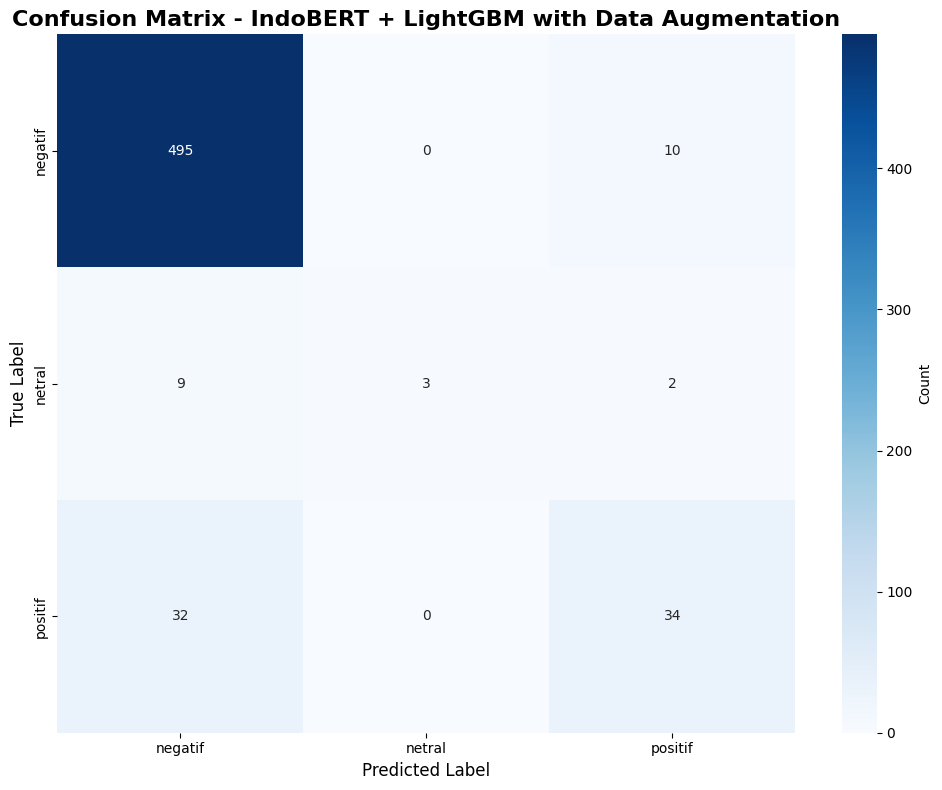


Confusion matrix saved as 'confusion_matrix_lightgbm_augmented.png'


In [8]:
# ==================== EVALUATION ====================
print("\n" + "="*80)
print("STEP 7: EVALUATION")
print("="*80)

# Validation
y_val_pred = np.argmax(lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration), axis=1)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set:")
print(f"Validation Accuracy: {val_acc:.4f}")

# Test
y_test_pred = np.argmax(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration), axis=1)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set:")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
target_names = ['negatif', 'netral', 'positif']
print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - IndoBERT + LightGBM with Data Augmentation', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_lightgbm_augmented.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'confusion_matrix_lightgbm_augmented.png'")




STEP 8: SAVING MODEL & PREDICTIONS

LightGBM model saved to 'lightgbm_indobert_absa_augmented.txt'
Test predictions saved to 'test_predictions_lightgbm_augmented.csv'


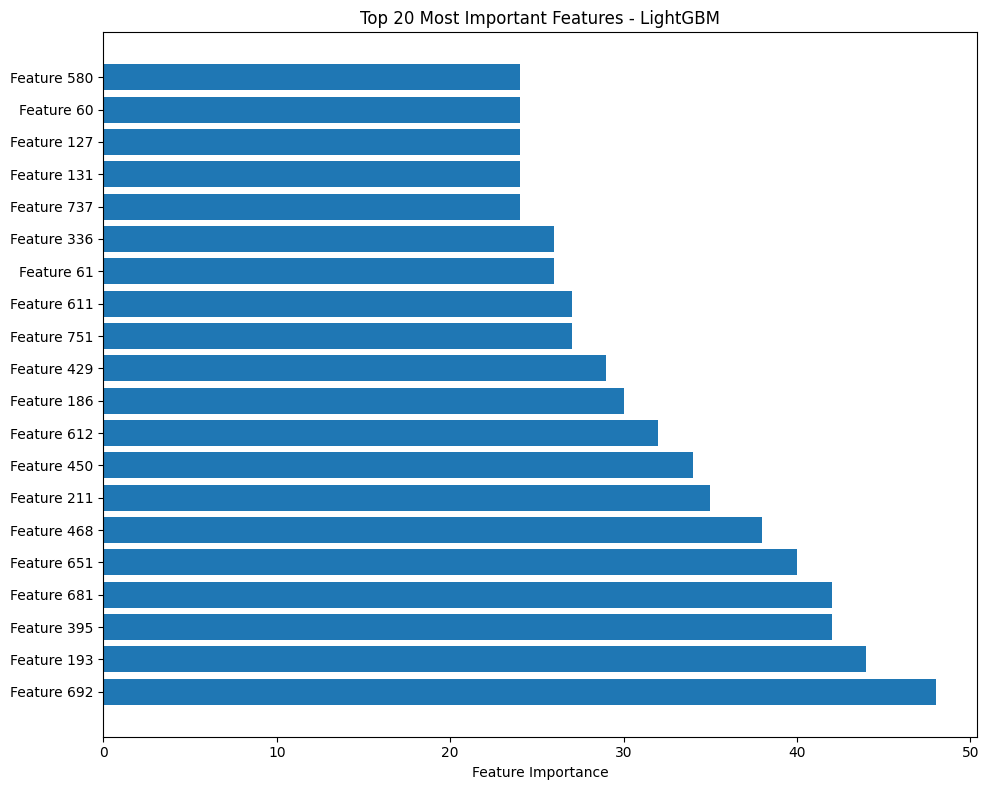

Feature importance plot saved as 'feature_importance_lightgbm.png'

TRAINING & EVALUATION COMPLETED!

Files generated:
  1. lightgbm_indobert_absa_augmented.txt - LightGBM model
  2. confusion_matrix_lightgbm_augmented.png - Confusion matrix
  3. test_predictions_lightgbm_augmented.csv - Test set predictions
  4. feature_importance_lightgbm.png - Feature importance plot


In [9]:
# ==================== SAVE MODEL & PREDICTIONS ====================
print("\n" + "="*80)
print("STEP 8: SAVING MODEL & PREDICTIONS")
print("="*80)

# Save LightGBM model
lgb_model.save_model('lightgbm_indobert_absa_augmented.txt')
print("\nLightGBM model saved to 'lightgbm_indobert_absa_augmented.txt'")

# Save predictions
test_df_copy = test_df.copy()
test_df_copy['predicted_label'] = y_test_pred
test_df_copy['predicted_polaritas'] = test_df_copy['predicted_label'].map(inv_label_map)

test_df_copy.to_csv('test_predictions_lightgbm_augmented.csv', index=False)
print("Test predictions saved to 'test_predictions_lightgbm_augmented.csv'")

# Feature importance
feature_importance = lgb_model.feature_importance()
top_features_idx = np.argsort(feature_importance)[-20:][::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
plt.yticks(range(len(top_features_idx)), 
           [f'Feature {idx}' for idx in top_features_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features - LightGBM')
plt.tight_layout()
plt.savefig('feature_importance_lightgbm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance plot saved as 'feature_importance_lightgbm.png'")

print("\n" + "="*80)
print("TRAINING & EVALUATION COMPLETED!")
print("="*80)
print(f"\nFiles generated:")
print(f"  1. lightgbm_indobert_absa_augmented.txt - LightGBM model")
print(f"  2. confusion_matrix_lightgbm_augmented.png - Confusion matrix")
print(f"  3. test_predictions_lightgbm_augmented.csv - Test set predictions")
print(f"  4. feature_importance_lightgbm.png - Feature importance plot")